# Comparing a USGSCSM and ISIS camera for Messenger MDIS NAC

In [17]:
import os 

os.environ["ISISROOT"] = "/usgs/cpkgs/anaconda3_linux/envs/isis3.7.0"

import pysis
from pysis import isis
from pysis.exceptions import ProcessError

import knoten
from knoten import vis

import json

import ale
from ale import util
from ale.drivers.messenger_drivers import MessengerMdisPds3NaifSpiceDriver
from ale.formatters.usgscsm_formatter import to_usgscsm

from IPython.display import Image

import plotly
plotly.offline.init_notebook_mode(connected=True)

## Download Image

In [2]:
imageLink = 'https://pds-imaging.jpl.nasa.gov/data/messenger/MDIS/MDIS/MSGRMDS_1001/DATA/2015_114/EN1072174528M.IMG'
!wget -N -P data/ {imageLink}
fileName = 'data/' + os.path.split(imageLink)[1]


--2019-08-02 15:19:09--  https://pds-imaging.jpl.nasa.gov/data/messenger/MDIS/MDIS/MSGRMDS_1001/DATA/2015_114/EN1072174528M.IMG
Resolving pds-imaging.jpl.nasa.gov (pds-imaging.jpl.nasa.gov)... 128.149.114.60
Connecting to pds-imaging.jpl.nasa.gov (pds-imaging.jpl.nasa.gov)|128.149.114.60|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 269312 (263K) [application/octet-stream]
Server file no newer than local file ‘data/EN1072174528M.IMG’ -- not retrieving.



## Ingest the image and spiceinit

In [3]:
# Set the output location of the resulting .cub
cub_loc = os.path.splitext(fileName)[0] + '.cub'
json_loc = os.path.splitext(fileName)[0] + '.json'

try: 
    isis.mdis2isis(from_=fileName, to=cub_loc)
except ProcessError as e:
    print(e.stderr)

try:
    isis.spiceinit(from_=cub_loc, shape='ellipsoid')
except ProcessError as e:
    print(e.stderr)

with MessengerMdisPds3NaifSpiceDriver(fileName) as driver:
    usgscsmString = to_usgscsm(driver)
    usgscsm_dict = json.loads(usgscsmString)
    
    csm_isd = os.path.splitext(fileName)[0] + '.json'
    json.dump(usgscsm_dict, open(csm_isd, 'w'))
    
camera = knoten.csm.create_csm(fileName)

## Compare USGS CSM and ISIS pixels

In [4]:
csmisis_diff_lv_plot, csmisis_diff_ephem_plot, external_orientation_data = vis.external_orientation_diff(csm_isd, cub_loc, 2, 2, 600, 600)

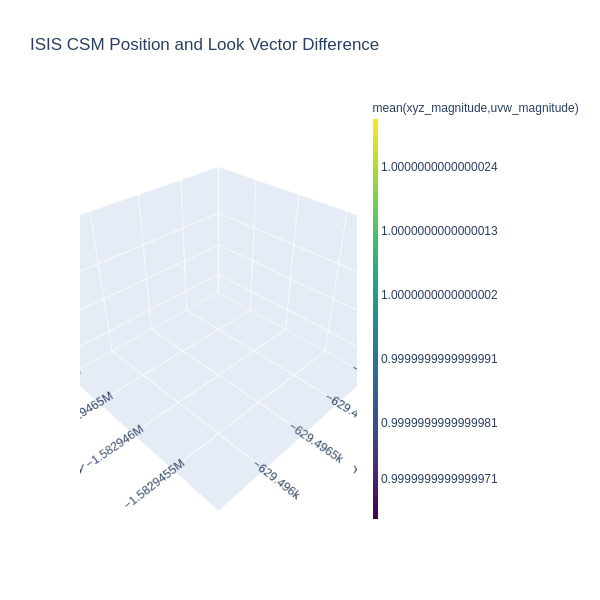

In [5]:
csmisis_diff_lv_plot_bytes = csmisis_diff_lv_plot.to_image(format="png")
csmisis_diff_ephem_plot_bytes = csmisis_diff_ephem_plot.to_image(format="png")
Image(csmisis_diff_lv_plot_bytes)

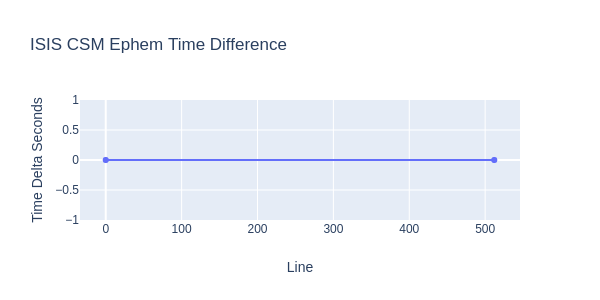

In [6]:
Image(csmisis_diff_ephem_plot_bytes)

In [7]:
external_orientation_data[['diffx', 'diffy', 'diffz', 'diffu', 'diffv', 'diffw']].describe()

,diffx,diffy,diffz,diffu,diffv,diffw
count,4.000000,4.00000,4.00000,4.000000,4.000000,4.000000
mean,0.016048,-0.00657,-0.00014,0.006501,0.000026,-0.000116
std,0.000000,0.00000,0.00000,0.007495,0.000043,0.000123
min,0.016048,-0.00657,-0.00014,0.000009,-0.000011,-0.000225
25%,0.016048,-0.00657,-0.00014,0.000010,-0.000011,-0.000221
50%,0.016048,-0.00657,-0.00014,0.006487,0.000025,-0.000115
75%,0.016048,-0.00657,-0.00014,0.012978,0.000061,-0.000010
max,0.016048,-0.00657,-0.00014,0.013019,0.000066,-0.000010


In [8]:
isis2csm_plot, csm2isis_plot, isiscsm_plotlatlon, isiscsm_plotbf, isis2csm_data, csm2isis_data, isiscsm_latlondata, isiscsm_bfdata = vis.reprojection_diff(csm_isd, cub_loc, 10, 10, 500, 500)

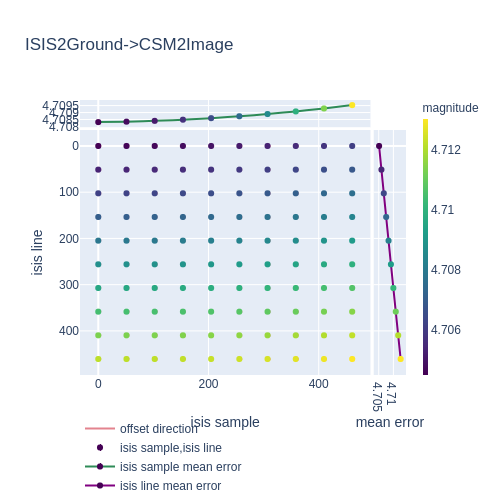

In [9]:
Image(isis2csm_plot.to_image())

In [10]:
isis2csm_data[['diff line', 'diff sample']].describe()

,diff line,diff sample
count,100.000000,100.000000
mean,0.286851,4.700021
std,0.001425,0.002438
min,0.283925,4.695550
25%,0.285753,4.698071
50%,0.286827,4.699983
75%,0.287909,4.702053
max,0.289764,4.704470


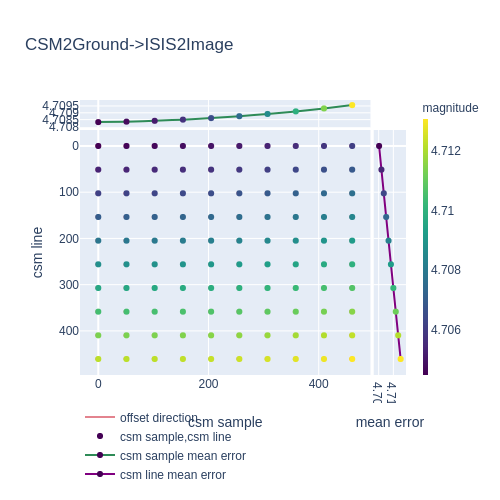

In [11]:
Image(csm2isis_plot.to_image())

In [12]:
csm2isis_data[['diff line', 'diff sample']].describe()

,diff line,diff sample
count,100.000000,100.000000
mean,-0.286809,-4.700041
std,0.001426,0.002437
min,-0.289721,-4.704496
25%,-0.287871,-4.702074
50%,-0.286781,-4.700003
75%,-0.285709,-4.698084
max,-0.283883,-4.695563


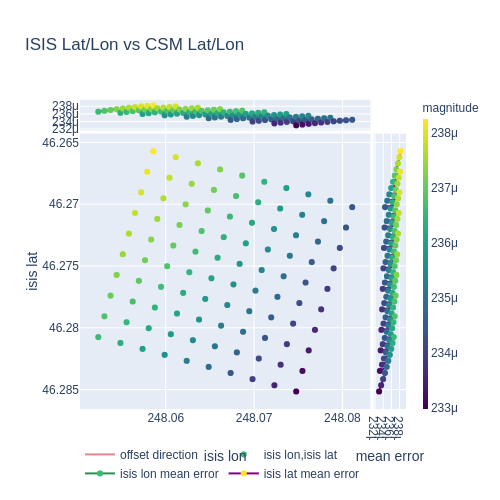

In [13]:
Image(isiscsm_plotlatlon.to_image())

In [14]:
isiscsm_latlondata[['diff lon', 'diff lat']].describe()

,diff lon,diff lat
count,100.000000,100.000000
mean,0.000233,0.000036
std,0.000001,0.000001
min,0.000230,0.000034
25%,0.000232,0.000035
50%,0.000233,0.000036
75%,0.000234,0.000037
max,0.000236,0.000039


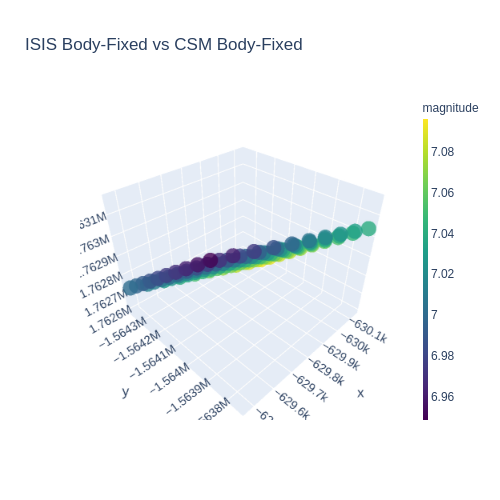

In [15]:
Image(isiscsm_plotbf.to_image())

In [16]:
isiscsm_bfdata[['diffx', 'diffy', 'diffz']].describe()

,diffx,diffy,diffz
count,100.000000,100.000000,100.000000
mean,-0.609946,1.526732,-1.066319
std,0.028120,0.045368,0.032680
min,-0.668687,1.438338,-1.136458
25%,-0.632235,1.488495,-1.090273
50%,-0.609363,1.527683,-1.066109
75%,-0.586523,1.565349,-1.040366
max,-0.558120,1.603576,-1.001166
